In [214]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import statsmodels.api as sm
import sys
from stocktrends import Renko
import talib
import yfinance as yf
import copy
from alpha_vantage.timeseries import TimeSeries
from collections import OrderedDict
from operator import itemgetter

In [215]:
# !{sys.executable} -m pip install ...

### Tech indicators

In [216]:
def ATR(DF, n):
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
#     df['ATR'] = df['TR'].ewm(span=n, adjust=False, min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2['ATR']

### KPI for the strategy

In [217]:
def CAGR(DF):
    df = DF.copy()
#     df['daily_ret'] = df['close'].pct_change()
    df['cum_ret'] = (1 + df['ret']).cumprod()
#     print(df)
    n = len(df) / (252 * 78)
    CAGR = (df['cum_ret'].tolist()[-1]) ** (1/n) - 1
    return CAGR


def Vola(DF):
    df = DF.copy()
#     df['daily_ret'] = df['close'].pct_change()
    vola = df['ret'].std()
    volatility = vola * np.sqrt(252 * 78)
#     annual_vola = vola * np.sqrt(12)
# #     week_vola = vola * np.sqrt(52)
#     month_vola = vola * np.sqrt(12)
    return volatility


def Sharpe(DF, rf):
    df = DF.copy()
    sr = ((CAGR(df) - rf) / Vola(df))
    return sr


def Sortino(DF, rf):
    df = DF.copy()
    df['ret'] = df['close'].pct_change()
    neg_vola = df[df['ret'] < 0]['ret'].std() * np.sqrt(252 * 78)
    sortino = (CAGR(df) - rf) / neg_vola
    return sortino


def max_dd(DF):
    df = DF.copy()
#     df['mon_ret'] = df['close'].pct_change()
    df['cum_ret'] = (1 + df['ret']).cumprod()
    df['cum_roll_max'] = df['cum_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cum_ret']
    df['drawdown_pct'] = df['drawdown'] / df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd


def Calmar(DF):
    df = DF.copy()
    clmr = CAGR(df) / max_dd(df)
    return clmr 

### Data fetching

##### Bitcoin

In [218]:
# start_date = '20140101'
# # end_date = '20191101'
# end_date = time.strftime("%Y%m%d")

In [219]:
# url ="https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=" + start_date + "&end=" + end_date
# example_df = pd.read_html(url)

# data = example_df[2]
# df =pd.DataFrame(data)

# df['Date'] =  pd.to_datetime(df['Date']) # date
# df.columns = ['Date','Open','High','Low','Close','Volume','Market Cap']
# df.set_index('Date',inplace=True)
# df.sort_index(inplace=True)


##### Stocks

In [220]:
tickers = ['AAPL', 'MMM', 'AMZN', 'MSFT', 'IBM', 'CAT', 'TSLA', 'EW']

start_date_stocks = '2000-01-01'
# end_date = 

In [221]:
ohlc_intraday = {} # to store stock data
key_path = 'IFOZ40XUSKNEY85Z'
ts = TimeSeries(key=key_path, output_format='pandas')
# ts = timeseries(key=open(key_path, 'r').read(), output_format='pandas')

attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store stock whose close price was successfuly extracted

while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks which tiker has been extracted
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i], interval = '5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            ohlc_intraday[tickers[i]].sort_index(inplace=True)
            drop.append(tickers[i])
        except:
            print(tickers[i], 'failed to fetch data..retrying')
            continue
    attempt += 1


tickers = ohlc_intraday.keys() #redefine tickers variable after removing any tickers with corrupted data


AMZNMSFT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying
AMZNMSFT failed to fetch data..retrying
AMZNMSFT failed to fetch data..retrying
AMZNMSFT failed to fetch data..retrying
AMZNMSFT failed to fetch data..retrying
AMZNMSFT failed to fetch data..retrying


In [222]:
# calculating ATR and rolliing max price for each sock and consolidation info by stock in a series
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print('calculating ATR and rolling max price for', ticker)
    ohlc_dict[ticker]['ATR'] = ATR(ohlc_dict[ticker], 20)
    ohlc_dict[ticker]['roll_max_cp'] = ohlc_dict[ticker]['High'].rolling(20).max()
    ohlc_dict[ticker]['roll_min_cp'] = ohlc_dict[ticker]['Low'].rolling(20).min()
    ohlc_dict[ticker]['roll_max_vol'] = ohlc_dict[ticker]['Volume'].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ''
    tickers_ret[ticker] = []

calculating ATR and rolling max price for AAPL
calculating ATR and rolling max price for MMM
calculating ATR and rolling max price for IBM
calculating ATR and rolling max price for CAT
calculating ATR and rolling max price for TSLA
calculating ATR and rolling max price for EW


In [223]:
for ticker in tickers:
    print('calculating returns for ',ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == '':
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]['High'][i] >= ohlc_dict[ticker]['roll_max_cp'][i] and \
               ohlc_dict[ticker]['Volume'][i] > 1.5 * ohlc_dict[ticker]['roll_max_vol'][i-1]:
                tickers_signal[ticker] = 'Buy'
            elif ohlc_dict[ticker]['Low'][i] <= ohlc_dict[ticker]['roll_min_cp'][i] and \
               ohlc_dict[ticker]['Volume'][i] > 1.5 * ohlc_dict[ticker]['roll_max_vol'][i-1]:
                tickers_signal[ticker] = 'Sell'
        
        elif tickers_signal[ticker] == 'Buy':
            if ohlc_dict[ticker]['Close'][i] < ohlc_dict[ticker]['Close'][i-1] - ohlc_dict[ticker]['ATR'][i-1]:
                tickers_signal[ticker] = ''
                tickers_ret[ticker].append(((ohlc_dict[ticker]['Close'][i-1] - ohlc_dict[ticker]['ATR'][i-1])/ohlc_dict[ticker]['Close'][i-1])-1)
            elif ohlc_dict[ticker]['Low'][i] <= ohlc_dict[ticker]['roll_min_cp'][i] and \
               ohlc_dict[ticker]['Volume'][i] > 1.5 * ohlc_dict[ticker]['roll_max_vol'][i-1]:
                tickers_signal[ticker] = 'Sell'
                tickers_ret[ticker].append(((ohlc_dict[ticker]['Close'][i-1] - ohlc_dict[ticker]['ATR'][i-1]) / ohlc_dict[ticker]['Close'][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i] / ohlc_dict[ticker]['Close'][i-1])-1)
        
        elif tickers_signal[ticker] == 'Sell':
            if ohlc_dict[ticker]['Close'][i] > ohlc_dict[ticker]['Close'][i-1] + ohlc_dict[ticker]['ATR'][i-1]:
                tickers_signal[ticker] = ''
                tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i-1] / (ohlc_dict[ticker]['Close'][i-1] + ohlc_dict[ticker]['ATR'][i-1]))-1)
            elif ohlc_dict[ticker]['High'][i] >= ohlc_dict[ticker]['roll_max_cp'][i] and \
               ohlc_dict[ticker]['Volume'][i] > 1.5 * ohlc_dict[ticker]['roll_max_vol'][i-1]:
                tickers_signal[ticker] = 'Buy'
                tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i-1] / (ohlc_dict[ticker]['Close'][i-1] + ohlc_dict[ticker]['ATR'][i-1]))-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]['Close'][i-1]/ohlc_dict[ticker]['Close'][i])-1)
                
    ohlc_dict[ticker]['ret'] = np.array(tickers_ret[ticker])

calculating returns for  AAPL
calculating returns for  MMM
calculating returns for  IBM
calculating returns for  CAT
calculating returns for  TSLA
calculating returns for  EW


In [224]:
# calculating overall strategy's KPI

strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]['ret']
strategy_df['ret'] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(Sharpe(strategy_df, 0))
print(max_dd(strategy_df))

0.8622088520713982
24.128487074461944
0.003166500298088613


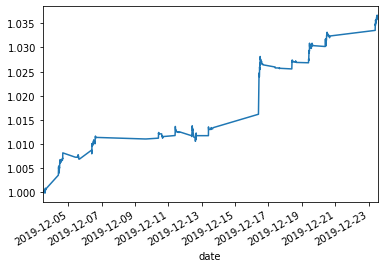

In [225]:
# vizualization of strategy return
(1 + strategy_df['ret']).cumprod().plot();

In [226]:
strategy_df

,AAPL,MMM,IBM,CAT,TSLA,EW,ret
date,,,,,,,
2019-12-03 11:15:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-12-03 11:20:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-12-03 11:25:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-12-03 11:30:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-12-03 11:35:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
2019-12-23 12:45:00,0.0,0.0,0.0,0.0,-0.001052,0.0,-0.000175
2019-12-23 12:50:00,0.0,0.0,0.0,0.0,-0.000404,0.0,-0.000067
2019-12-23 12:55:00,0.0,0.0,0.0,0.0,0.000547,0.0,0.000091


In [227]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  Sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=['Return', 'Sharpe Ratio', 'Max Drawdown'])      
KPI_df.T

calculating KPIs for  AAPL
calculating KPIs for  MMM
calculating KPIs for  IBM
calculating KPIs for  CAT
calculating KPIs for  TSLA
calculating KPIs for  EW


,Return,Sharpe Ratio,Max Drawdown
AAPL,0.817132,11.323745,0.007975
MMM,1.178825,12.840476,0.007321
IBM,0.110152,3.103529,0.003841
CAT,0.530466,6.459210,0.015115
TSLA,3.472848,27.975154,0.008175
EW,0.365595,7.957903,0.004363
